# Capítulo 8 - Métodos Policy Gradient


Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap08/cap08-main.ipynb) 

Para rodar localmente, primeiro, baixe todo o repositório do github: https://github.com/pablo-sampaio/rl_facil.

## 1. Configurações Iniciais

### Cria Diretório para Experimentos

In [1]:
!mkdir results

### Configurações Dependentes do Sistema

Rode a célula abaixo, mesmo sem estar no Colab.

In [2]:
import sys
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install gym
    !pip install gym[box2d]
    !pip install optuna

    # para salvar videos
    !apt-get install -y xvfb x11-utils
    !pip install pyvirtualdisplay==0.2.*
    !apt-get install ffmpeg

    from pyvirtualdisplay import Display
    global display
    display = Display(visible=False, size=(1400, 900))
    _ = display.start()

    !git clone https://github.com/pablo-sampaio/rl_facil
    clear_output()

    !mv /content/rl_facil/cap04/util* /content/
    !mv /content/rl_facil/cap06/models_* /content/
    !mv /content/rl_facil/cap08/* /content/

else:
    # atenção: para Windows apenas! 
    # se estiver no Linux, troque por "copy" por "cp" e mude a barra
    !copy ..\cap04\util_*.py .
    !copy ..\cap06\models_*.py .


### Configurações para Exibir Video

In [3]:
# ideias adaptadas de : https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
from base64 import b64encode
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  html_code = f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
  return HTML(html_code)

### Imports Principais

Import algoritmos, ambientes e outros módulos.

In [8]:
import gym
import numpy as np
import optuna

from util_experiments import repeated_exec
from util_plot import plot_result, plot_multiple_results

from models_torch import test_policy
from reinforce import run_reinforce, PolicyModelPG
from reinforce_advantage import run_advantage_reinforce

## 2 - Rodando o Reinforce (Vanilla Policy Gradient)

In [22]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20
ENV = gym.make(ENV_NAME)

EPISODES = 2000

inputs = ENV.observation_space.shape[0]
outputs = ENV.action_space.n
policy = PolicyModelPG(inputs, [128, 512], outputs, lr=0.0005)

returns, policy = run_reinforce(ENV, EPISODES, 0.95, initial_policy=policy, target_return=200.0)

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))


- episode 1 (step 9): loss_p=3.33356, ep_return=9.00
- episode 2 (step 24): loss_p=4.44235, ep_return=15.00
- episode 3 (step 47): loss_p=5.93858, ep_return=23.00
- episode 4 (step 66): loss_p=5.27778, ep_return=19.00
- episode 5 (step 80): loss_p=4.27570, ep_return=14.00
- episode 6 (step 92): loss_p=3.78248, ep_return=12.00
- episode 7 (step 118): loss_p=6.41290, ep_return=26.00
- episode 8 (step 140): loss_p=5.79820, ep_return=22.00
- episode 9 (step 151): loss_p=3.39017, ep_return=11.00
- episode 10 (step 172): loss_p=5.63874, ep_return=21.00
- episode 11 (step 201): loss_p=6.88458, ep_return=29.00
- episode 12 (step 252): loss_p=9.14720, ep_return=51.00
- episode 13 (step 267): loss_p=4.51220, ep_return=15.00
- episode 14 (step 301): loss_p=7.51374, ep_return=34.00
- episode 15 (step 318): loss_p=4.90814, ep_return=17.00
- episode 16 (step 329): loss_p=3.43202, ep_return=11.00
- episode 17 (step 342): loss_p=3.90422, ep_return=13.00
- episode 18 (step 368): loss_p=6.36819, ep_retu

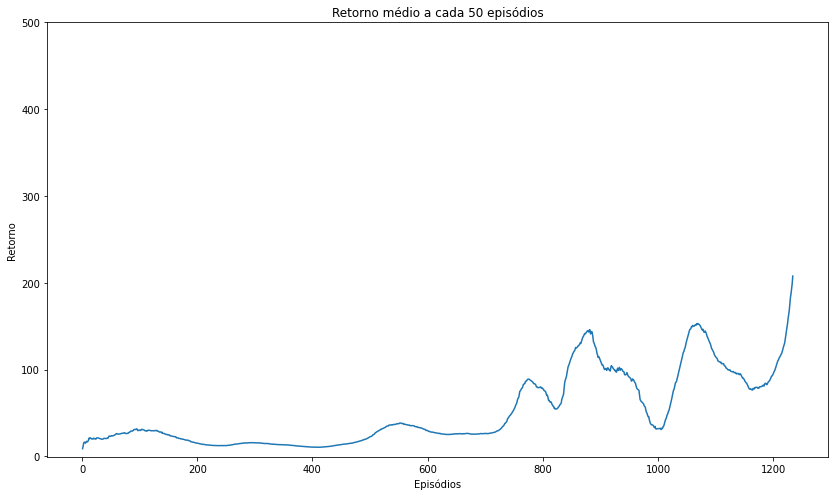

In [23]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax, 50)

In [24]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva o vídeo em arquivo
video = VideoRecorder(ENV, f"politica-reinforce-{ENV_NAME}.mp4")
test_policy(ENV, policy, True, 5, render=False, videorec=video)


EPISODE 1
- steps: 500
- return: 500.0
EPISODE 2
- steps: 229
- return: 229.0
EPISODE 3
- steps: 500
- return: 500.0
EPISODE 4
- steps: 500
- return: 500.0
EPISODE 5
- steps: 228
- return: 228.0
RESULTADO FINAL: média (por episódio): 391.4, episódios: 5, total de passos: 1957


(391.4, [500.0, 229.0, 500.0, 500.0, 228.0])

In [25]:
render_mp4(f"politica-reinforce-{ENV_NAME}.mp4")

## 3 - Rodando o Reinforce com Advantage

In [18]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20

ENV = gym.make(ENV_NAME)

EPISODES = 2000
GAMMA    = 0.95

inputs = ENV.observation_space.shape[0]
outputs = ENV.action_space.n
policy = PolicyModelPG(inputs, [128, 512], outputs, lr=0.001)

returns, policy = run_advantage_reinforce(ENV, EPISODES, GAMMA, initial_policy=policy, target_return=rmax-100)

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))

- episode 1 (step 29): losses[v/p]=6.74181/115.10405, ep_return=29.00
- episode 2 (step 49): losses[v/p]=5.19932/70.22959, ep_return=20.00
- episode 3 (step 81): losses[v/p]=6.72624/120.27367, ep_return=32.00
- episode 4 (step 124): losses[v/p]=7.94568/156.42126, ep_return=43.00
- episode 5 (step 141): losses[v/p]=3.97413/48.80515, ep_return=17.00
- episode 6 (step 152): losses[v/p]=2.23482/21.36344, ep_return=11.00
- episode 7 (step 164): losses[v/p]=2.36654/21.32907, ep_return=12.00
- episode 8 (step 190): losses[v/p]=4.87794/79.24683, ep_return=26.00
- episode 9 (step 200): losses[v/p]=1.35622/12.35996, ep_return=10.00
- episode 10 (step 212): losses[v/p]=1.28234/18.02726, ep_return=12.00
- episode 11 (step 227): losses[v/p]=1.89700/27.92359, ep_return=15.00
- episode 12 (step 244): losses[v/p]=2.59591/35.33520, ep_return=17.00
- episode 13 (step 266): losses[v/p]=3.70777/53.19687, ep_return=22.00
- episode 14 (step 277): losses[v/p]=0.49293/14.41317, ep_return=11.00
- episode 15 (s

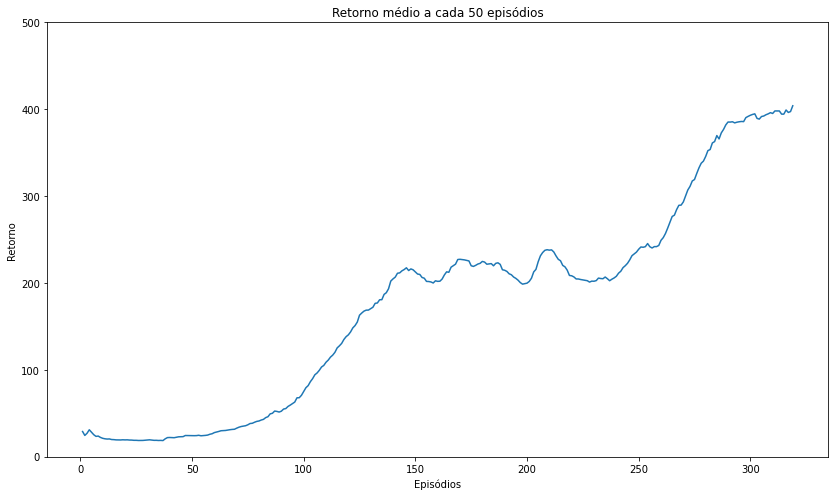

In [19]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax, 50)

In [20]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva o vídeo em arquivo
video = VideoRecorder(ENV, f"politica-reinf-advant-{ENV_NAME}.mp4")
test_policy(ENV, policy, True, 5, render=False, videorec=video)

EPISODE 1
- steps: 500
- return: 500.0
EPISODE 2
- steps: 500
- return: 500.0
EPISODE 3
- steps: 500
- return: 500.0
EPISODE 4
- steps: 500
- return: 500.0
EPISODE 5
- steps: 500
- return: 500.0
RESULTADO FINAL: média (por episódio): 500.0, episódios: 5, total de passos: 2500


(500.0, [500.0, 500.0, 500.0, 500.0, 500.0])

In [21]:
render_mp4(f"politica-reinf-advant-{ENV_NAME}.mp4")

## 3 - Experimentos


### 3.1 Comparações entre os Métodos


In [ ]:
ENV = gym.make("CartPole-v1")
NUM_EPISODES = 700

results = []

for batch_size in [5, 20]:
    #results = []
    for proportion in [1/5.0, 2/5.0, 4/5.0]:
        results.append( repeated_exec(5, f"Reinforce ({batch_size}; {proportion:.2f})", ?, ENV, NUM_EPISODES, batch_size, proportion) )
        clear_output()
    #plot_multiple_results(results, cumulative=False, x_log_scale=False)

plot_multiple_results(results, cumulative=False, x_log_scale=False)


### 3.2 Parâmetros da Rede Neural (da Política)

Você também pode variar todos os parâmetros da rede neural: quantidade de camadas, taxa de aprendizagem, etc.

In [ ]:
ENV = gym.make("CartPole-v1")

NUM_EPISODES = 400

print("Observation Space - ", ENV.observation_space.shape)
print("Observation Space - shape", ENV.observation_space.shape)
print("Action Space - ", ENV.action_space)
print("Action Space - number of actions - ", ENV.action_space.n)

In [ ]:
results = []

for hidden_layer_size in [16, 128]:
    policy_model = PolicyModelPG(ENV.observation_space.shape[0], [hidden_layer_size], ENV.action_space.n, lr=0.01)
    results.append( repeated_exec(5, f"Reinforce (hnodes={hidden_layer_size})", ?, ENV, NUM_EPISODES, BATCH_SIZE, PROPORTION, policy_model) )
    clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)